In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, io, restoration
from skimage.metrics import peak_signal_noise_ratio
from scipy.signal import convolve2d
from scipy.optimize import minimize

#### 1. Non blind image deblurring

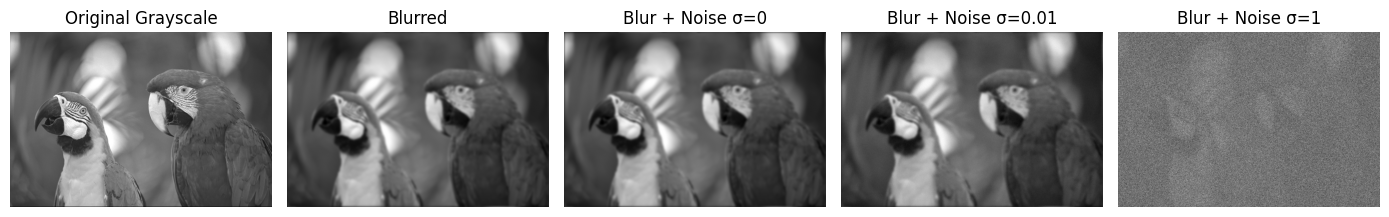

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# --- Step 1: Load image and convert to grayscale ---
image = plt.imread("macau.png").astype(float)
if image.ndim == 3:  # Convert RGB to grayscale
    gray = 0.299 * image[..., 0] + 0.587 * image[..., 1] + 0.114 * image[..., 2]
else:
    gray = image

# --- Step 2: Define blur kernel (PSF) ---
psf = np.ones((9, 9)) / 81  # uniform blur kernel

def gaussian_psf(size=9, sigma=2.0):
    """
    Generate a 2D Gaussian PSF (normalized).

    size : int
        Size of the kernel (must be odd, e.g. 3, 5, 7, 9).
    sigma : float
        Standard deviation of the Gaussian.

    Returns:
        psf : (size, size) numpy array, normalized to sum = 1.
    """
    # coordinate grid (centered)
    ax = np.arange(-(size//2), size//2 + 1)
    xx, yy = np.meshgrid(ax, ax)

    # Gaussian formula
    psf = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))

    # Normalize
    psf /= psf.sum()
    return psf


psf = gaussian_psf(size=15, sigma=3)

# --- Step 3: Apply blur ---
blurry = convolve2d(gray, psf, mode='same', boundary='wrap')

# --- Step 4: Noise function ---
def add_gaussian_noise(image, sigma):
    """Add Gaussian noise with given sigma to an image."""
    noise = sigma * np.random.standard_normal(image.shape)
    return image + noise

# --- Step 5: Generate noisy versions ---
sigmas = [0, 0.01, 1]
noisy_images = [add_gaussian_noise(blurry, s) for s in sigmas]

# --- Step 6: Plot results ---
plt.figure(figsize=(14, 5))

# Original
plt.subplot(1, len(sigmas)+2, 1)
plt.title("Original Grayscale")
plt.imshow(gray, cmap="gray")
plt.axis("off")

# Blurry (no noise)
plt.subplot(1, len(sigmas)+2, 2)
plt.title("Blurred")
plt.imshow(blurry, cmap="gray")
plt.axis("off")

# Noisy images for each sigma
for i, sigma in enumerate(sigmas):
    plt.subplot(1, len(sigmas)+2, i+3)
    plt.title(f"Blur + Noise σ={sigma}")
    plt.imshow(noisy_images[i], cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()

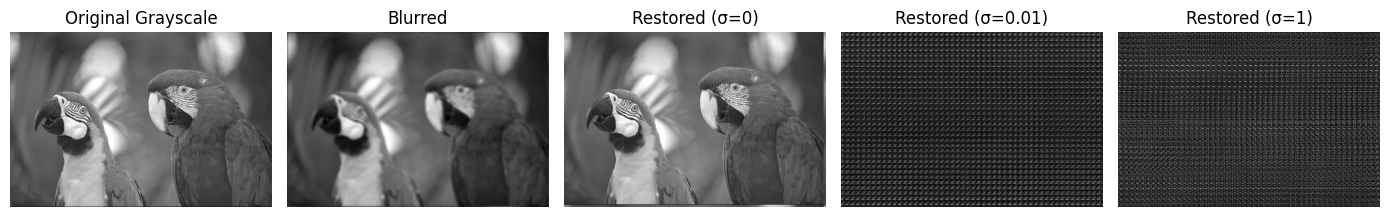

In [3]:
# --- Step 1: Define inverse filter ---
def inverse_filter_single(degraded, psf, eps=0):
    psf_padded = np.zeros_like(degraded)
    kh, kw = psf.shape
    psf_padded[:kh, :kw] = psf

    H = np.fft.fft2(psf_padded)
    H_conj = np.conj(H)
    H_mag2 = np.abs(H)**2

    G = np.fft.fft2(degraded)
    F_est = (H_conj / (H_mag2 + eps)) * G
    return np.abs(np.fft.ifft2(F_est))

# --- Step 2: Apply inverse filter for each noisy image ---
restored_images = [inverse_filter_single(img, psf) for img in noisy_images]

# --- Step 3: Plot results (same grid style) ---
plt.figure(figsize=(14, 5))

# Original
plt.subplot(1, len(sigmas)+2, 1)
plt.title("Original Grayscale")
plt.imshow(gray, cmap="gray")
plt.axis("off")

# Blurry (no noise)
plt.subplot(1, len(sigmas)+2, 2)
plt.title("Blurred")
plt.imshow(blurry, cmap="gray")
plt.axis("off")

# Restored images for each sigma
for i, sigma in enumerate(sigmas):
    plt.subplot(1, len(sigmas)+2, i+3)
    plt.title(f"Restored (σ={sigma})")
    plt.imshow(restored_images[i], cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Tasks

## 1. Frequency Domain Analysis

#### 1(a)  
Plot the frequency domain (magnitude spectrum) for:  
- The original image  
- The PSF (box filter)  
- The restored images  

#### 1(b)  
Compute the **magnitude of the FFT of the PSF** and note down the first 3 frequency values where this magnitude becomes zero, for the following cases:  
- eps = 0  
- eps = 1e-6  
- eps = 1e-3  

---

## 2. Effect of Wrong PSF in Deconvolution

#### 2(a)  
Blur the image with a **box filter**, but perform deconvolution using a **Gaussian filter**.  

#### 2(b)  
Blur the image with a **Gaussian filter**, but perform deconvolution using a **box filter**.  


## 1a

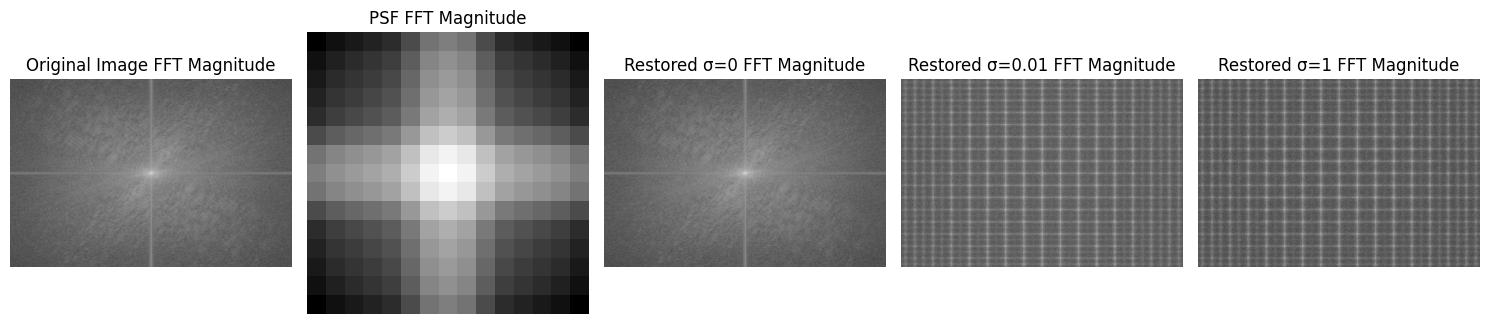

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fft_magnitude(image, title, ax):
    """
    Plot the magnitude spectrum of the FFT of an image or kernel.
    """
    F = np.fft.fft2(image)
    F_shifted = np.fft.fftshift(F)
    magnitude_spectrum = 20 * np.log(np.abs(F_shifted) + 1e-8)  # log scale for visibility
    
    ax.imshow(magnitude_spectrum, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

num_restored = len(restored_images)

plt.figure(figsize=(15, 4))

# Original image magnitude spectrum
plt.subplot(1, num_restored + 2, 1)
plot_fft_magnitude(gray, "Original Image FFT Magnitude", plt.gca())

# PSF magnitude spectrum
plt.subplot(1, num_restored + 2, 2)
plot_fft_magnitude(psf, "PSF FFT Magnitude", plt.gca())

# Plot all restored images magnitude spectrums
for i, restored_img in enumerate(restored_images):
    plt.subplot(1, num_restored + 2, i+3)
    plot_fft_magnitude(restored_img, f"Restored σ={sigmas[i]} FFT Magnitude", plt.gca())

plt.tight_layout()
plt.show()

## 1b

In [10]:
import numpy as np

def find_fft_magnitude_zeros(psf, eps_values, pad_size=256):
    """
    Compute and print first 3 frequency positions where the magnitude of FFT(PSF)
    is minimum (near zero) for different eps regularizer values.
    
    Parameters:
        psf : 2D numpy array
            The point spread function (kernel).
        eps_values : list or array
            List of epsilon (regularizer) values.
        pad_size : int
            Size to zero-pad PSF for frequency resolution.
    """
    # Zero pad PSF to pad_size x pad_size
    psf_padded = np.zeros((pad_size, pad_size))
    kh, kw = psf.shape
    psf_padded[:kh, :kw] = psf

    print(f"Shape of padded PSF for FFT: {psf_padded.shape}\n")

    for eps in eps_values:
        # Compute FFT
        H = np.fft.fft2(psf_padded)
        # Magnitude squared plus eps regularization as in inverse filter denominator
        H_mag = np.abs(H)**2 + eps

        # Find indices of the 3 smallest magnitudes (closest to zero)
        # We ignore the zero-frequency (DC) component at center index
        flat_indices = np.argsort(H_mag.ravel())
        
        # Convert to 2D indices
        coords = np.array(np.unravel_index(flat_indices, H_mag.shape)).T
        
        # Center frequencies around zero
        coords_centered = coords - pad_size // 2

        # Filter out the zero frequency index (0,0)
        filtered_coords = [c for c in coords_centered if not (c[0] == 0 and c[1] == 0)]

        # Take first 3 frequency positions closest to zero magnitude
        first_3 = filtered_coords[:3]

        print(f"eps = {eps}")
        print("First 3 frequency indices (row, col) where magnitude is minimum (near zero):")
        for i, freq in enumerate(first_3):
            print(f"{i+1}: {freq}")
        print("\n")

# Define epsilon values to test
eps_list = [0, 1e-6, 1e-3]

# Call function with given PSF and eps values
find_fft_magnitude_zeros(psf, eps_list)

Shape of padded PSF for FFT: (256, 256)

eps = 0
First 3 frequency indices (row, col) where magnitude is minimum (near zero):
1: [-25 -25]
2: [ 25 -25]
3: [-25  25]


eps = 1e-06
First 3 frequency indices (row, col) where magnitude is minimum (near zero):
1: [-25 -25]
2: [25 25]
3: [-25  25]


eps = 0.001
First 3 frequency indices (row, col) where magnitude is minimum (near zero):
1: [-25  25]
2: [25 25]
3: [-25 -25]




## 2a

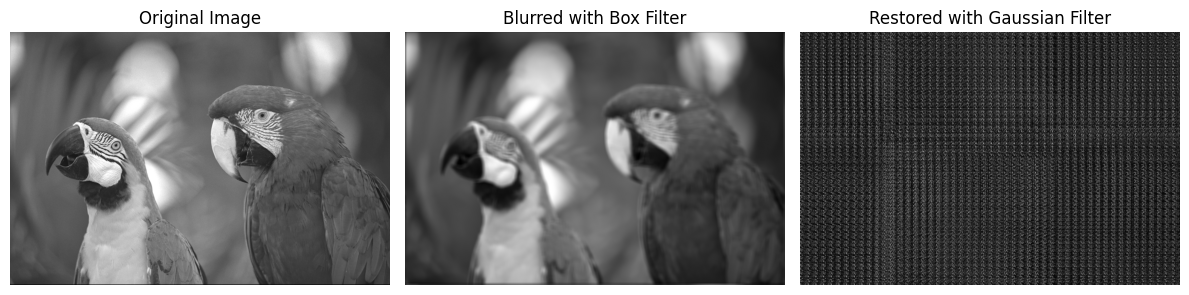

In [11]:
# Define box filter
box_psf = np.ones((9, 9)) / 81

# Blur image with box filter
blurry_box = convolve2d(gray, box_psf, mode='same', boundary='wrap')

# Deconvolve using Gaussian filter
restored_gaussian = inverse_filter_single(blurry_box, psf)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(gray, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Blurred with Box Filter")
plt.imshow(blurry_box, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Restored with Gaussian Filter")
plt.imshow(restored_gaussian, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

## 2b

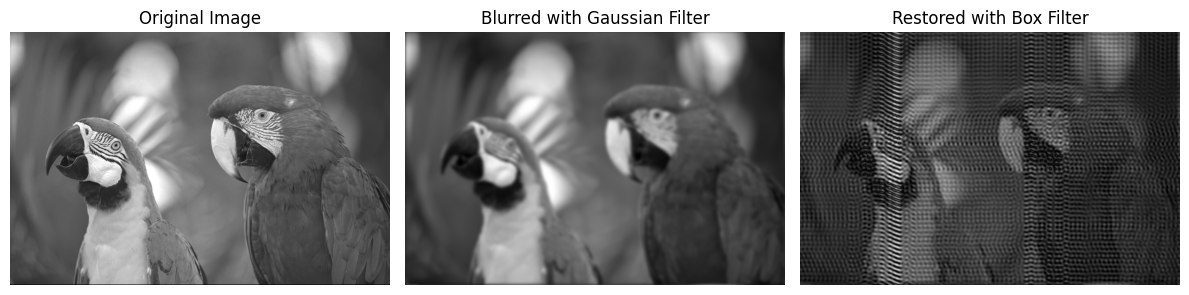

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# --- Define box filter PSF ---
def box_psf(size=9):
    psf = np.ones((size, size)) / (size * size)
    return psf

box_psf = box_psf(size=9)

# --- Step 1: Blur with Gaussian filter (psf) ---
blurry_gaussian = convolve2d(gray, psf, mode='same', boundary='wrap')

# --- Step 2: Deconvolve (inverse filter) using box filter ---
def inverse_filter_single(degraded, psf, eps=1e-6):
    psf_padded = np.zeros_like(degraded)
    kh, kw = psf.shape
    psf_padded[:kh, :kw] = psf

    H = np.fft.fft2(psf_padded)
    H_conj = np.conj(H)
    H_mag2 = np.abs(H)**2

    # Regularize denominator (eps avoids division by zero)
    G = np.fft.fft2(degraded)
    F_est = (H_conj / (H_mag2 + eps)) * G
    result = np.abs(np.fft.ifft2(F_est))
    # Replace any NaN/inf with 0 for display
    result = np.nan_to_num(result)
    return result

restored_box = inverse_filter_single(blurry_gaussian, box_psf, eps=1e-6)

# --- Step 3: Plot results ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(gray, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Blurred with Gaussian Filter")
plt.imshow(blurry_gaussian, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Restored with Box Filter")
plt.imshow(restored_box, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


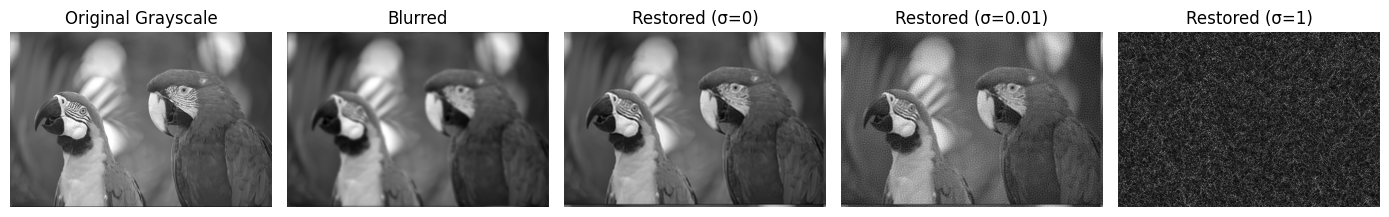

In [15]:
# --- Step 1: Define inverse filter ---
def inverse_filter_single(degraded, psf, eps=1e-3):
    psf_padded = np.zeros_like(degraded)
    kh, kw = psf.shape
    psf_padded[:kh, :kw] = psf

    H = np.fft.fft2(psf_padded)
    H_conj = np.conj(H)
    H_mag2 = np.abs(H)**2

    G = np.fft.fft2(degraded)
    F_est = (H_conj / (H_mag2 + eps)) * G
    return np.abs(np.fft.ifft2(F_est))

# --- Step 2: Apply inverse filter for each noisy image ---
restored_images = [inverse_filter_single(img, psf) for img in noisy_images]

# --- Step 3: Plot results (same grid style) ---
plt.figure(figsize=(14, 5))

# Original
plt.subplot(1, len(sigmas)+2, 1)
plt.title("Original Grayscale")
plt.imshow(gray, cmap="gray")
plt.axis("off")

# Blurry (no noise)
plt.subplot(1, len(sigmas)+2, 2)
plt.title("Blurred")
plt.imshow(blurry, cmap="gray")
plt.axis("off")

# Restored images for each sigma
for i, sigma in enumerate(sigmas):
    plt.subplot(1, len(sigmas)+2, i+3)
    plt.title(f"Restored (σ={sigma})")
    plt.imshow(restored_images[i], cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()

#  Wiener Deconvolution with Optimal `k`

We define the Wiener filter in the frequency domain as:

$$
\widehat{F}(u,v) \;=\; \frac{H^{\ast}(u,v)}{\lvert H(u,v)\rvert^{2} + k}\; G(u,v)
$$

**where:**

- **G(u,v)** — degraded (blurred + noisy) image in the frequency domain  
- **H(u,v)** — blur kernel (PSF) in the frequency domain  
- **H*(u,v)** — complex conjugate of the blur kernel   
- `k = 1/SNR` — regularization parameter

---

In [16]:
def estimate_snr(image):
    """Estimate SNR as mean/std of pixel intensities (toy model)."""
    img_mean = np.mean(image)
    img_std = np.std(image)
    return (img_mean / (img_std + 1e-8))  # avoid divide by zero

def wiener_inverse(degraded, psf):
    """
    Wiener deconvolution using toy SNR estimator.

    degraded : 2D numpy array (grayscale)
    psf      : 2D numpy array (blur kernel)
    """
    # Step 1: estimate SNR
    snr = estimate_snr(degraded)

    print("snr", snr)

    # Step 2: pad PSF to same size as image
    psf_padded = np.zeros_like(degraded)
    kh, kw = psf.shape
    psf_padded[:kh, :kw] = psf

    # Step 3: FFTs
    H = np.fft.fft2(psf_padded)
    G = np.fft.fft2(degraded)

    # Step 4: Wiener filter formula
    H_mag2 = np.abs(H)**2
    eps = 1e-12
    F_est = (H_mag2 / (H_mag2 + 1.0/snr)) * (G / (H + eps))

    # Step 5: inverse FFT back to spatial domain
    restored = np.real(np.fft.ifft2(F_est))
    return restored, snr


snr 2.4715924852028905
snr 2.467220074539099
snr 0.4234246952395514


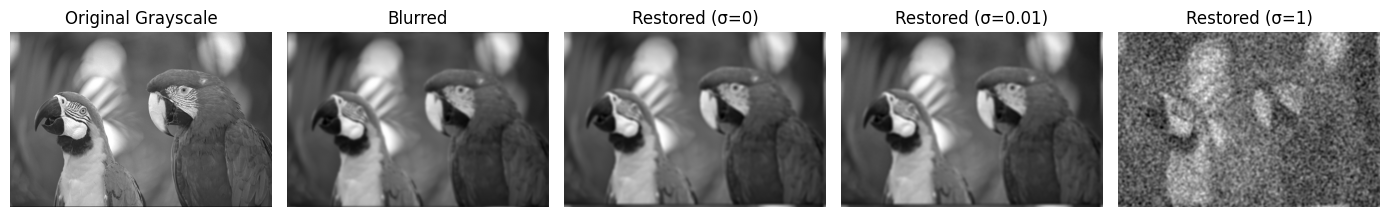

In [17]:
# --- Step 2: Apply inverse filter for each noisy image ---
restored_images = [wiener_inverse(img, psf)[0] for img in noisy_images]

# --- Step 3: Plot results (same grid style) ---
plt.figure(figsize=(14, 5))

# Original
plt.subplot(1, len(sigmas)+2, 1)
plt.title("Original Grayscale")
plt.imshow(gray, cmap="gray")
plt.axis("off")

# Blurry (no noise)
plt.subplot(1, len(sigmas)+2, 2)
plt.title("Blurred")
plt.imshow(blurry, cmap="gray")
plt.axis("off")

# Restored images for each sigma
for i, sigma in enumerate(sigmas):
    plt.subplot(1, len(sigmas)+2, i+3)
    plt.title(f"Restored (σ={sigma})")
    plt.imshow(restored_images[i], cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Problem

In the tutorial class and as illustrated in the code, I implied that SNR can be estimated from the image using the mean and standard deviation of the blurred and noisy image. However, this is not a reliable method because:  
- The noise also contributes to the mean of the blurred and noisy image, which is not ideal.  
- This problem is especially significant when the number of pixels (samples) is small.  

If we have access to the clean image, we can estimate the true mean, but this is not practical since real-world measured images are usually unclean.

---

### Key Points
- For a single image, we usually treat `k = 1/SNR` as a constant and vary it to get the best possible estimate of the clean image.  
- For a dataset with multiple analogous images, we can estimate the mean SNR from a batch of images and then apply Wiener deconvolution to get clean images.  

---

### Task

1. **Modify the `wiener_inverse` function**  
   - Make the SNR term (or equivalently the NSR term `k`) a constant that can be varied.  

2. **Experiment Setup**  
   - Take 3 images of your choice.  
   - Vary `k` in the range **0.01 to 2.0**, in steps of **0.001**.  
   - For each `k`, restore the image using Wiener deconvolution.  

3. **Error Metric**  
   Use the RMS error defined as:  

   $$
   \text{RMS}(k) \;=\; \sqrt{\frac{1}{N}\sum_{x,y}\big(I(x,y)-\widehat{I}_{k}(x,y)\big)^{2}}
   $$

   where:  
   - $I(x,y)$ = ground truth clean image  
   - $\widehat{I}_{k}(x,y)$ = restored image with parameter $k$  
   - $N$ = total number of pixels   

4. **Report the following**  
   - Optimal value of `k` (the one giving the minimum RMS error)  
   - Corresponding minimum RMS error  
   - **Plot:** RMS error vs. `k`  
   - **Visual comparison:**  
     - Original image  
     - Blurred image  
     - Restored image (with optimal `k`)  


### References
1.  https://www.youtube.com/watch?v=f-IINpceX6k ( Deconvolution)

In [27]:
image = plt.imread("download.jpeg").astype(float)
if image.ndim == 3:  # Convert RGB to grayscale
    gray = 0.299 * image[..., 0] + 0.587 * image[..., 1] + 0.114 * image[..., 2]
else:
    gray = image

psf = gaussian_psf(size=15, sigma=3)

# --- Step 3: Apply blur ---
blurry = convolve2d(gray, psf, mode='same', boundary='wrap')

sigmas = [0, 0.01, 1]

noisy_images = [add_gaussian_noise(blurry, s) for s in sigmas]

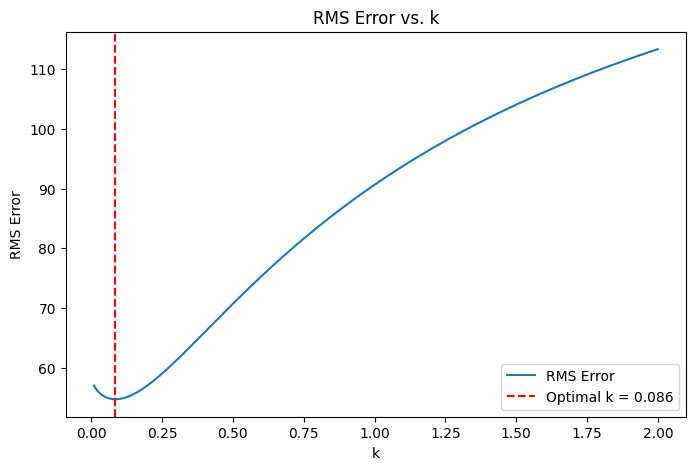

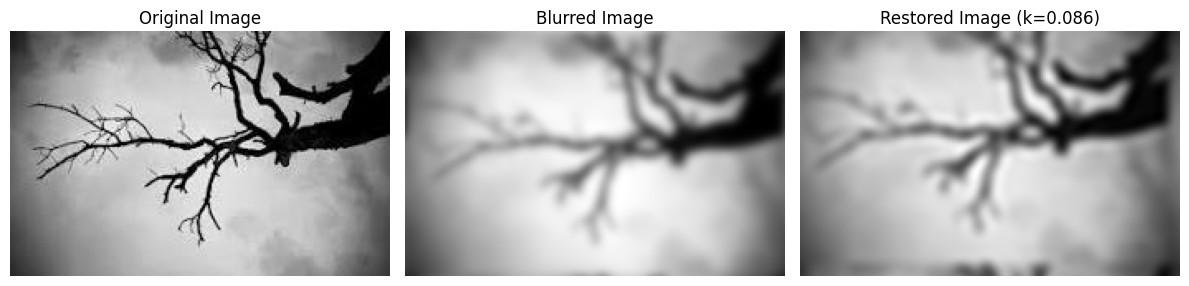

In [28]:
def wiener_inverse_with_k(degraded, psf, k):
    """
    Wiener deconvolution with user-defined k.
    """
    # Step 1: pad PSF to same size as image
    psf_padded = np.zeros_like(degraded)
    kh, kw = psf.shape
    psf_padded[:kh, :kw] = psf

    # Step 2: FFTs
    H = np.fft.fft2(psf_padded)
    G = np.fft.fft2(degraded)

    # Step 3: Wiener filter formula
    H_mag2 = np.abs(H)**2
    eps = 1e-12
    F_est = (H_mag2 / (H_mag2 + k)) * (G / (H + eps))

    # Step 4: inverse FFT back to spatial domain
    restored = np.real(np.fft.ifft2(F_est))
    return restored

# Experiment setup
k_values = np.arange(0.01, 2.0, 0.001)
rms_errors = []

for k in k_values:
    restored = wiener_inverse_with_k(blurry, psf, k)
    rms = np.sqrt(np.mean((gray - restored)**2))
    rms_errors.append(rms)

# Find optimal k
optimal_k = k_values[np.argmin(rms_errors)]
min_rms = np.min(rms_errors)

# Plot RMS error vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, rms_errors, label="RMS Error")
plt.axvline(optimal_k, color='r', linestyle='--', label=f"Optimal k = {optimal_k:.3f}")
plt.xlabel("k")
plt.ylabel("RMS Error")
plt.title("RMS Error vs. k")
plt.legend()
plt.show()

# Visual comparison
restored_optimal = wiener_inverse_with_k(blurry, psf, optimal_k)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(gray, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Blurred Image")
plt.imshow(blurry, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Restored Image (k={optimal_k:.3f})")
plt.imshow(restored_optimal, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

In [29]:
image = plt.imread("download (1).jpeg").astype(float)
if image.ndim == 3:  # Convert RGB to grayscale
    gray = 0.299 * image[..., 0] + 0.587 * image[..., 1] + 0.114 * image[..., 2]
else:
    gray = image

psf = gaussian_psf(size=15, sigma=3)

# --- Step 3: Apply blur ---
blurry = convolve2d(gray, psf, mode='same', boundary='wrap')

sigmas = [0, 0.01, 1]

noisy_images = [add_gaussian_noise(blurry, s) for s in sigmas]

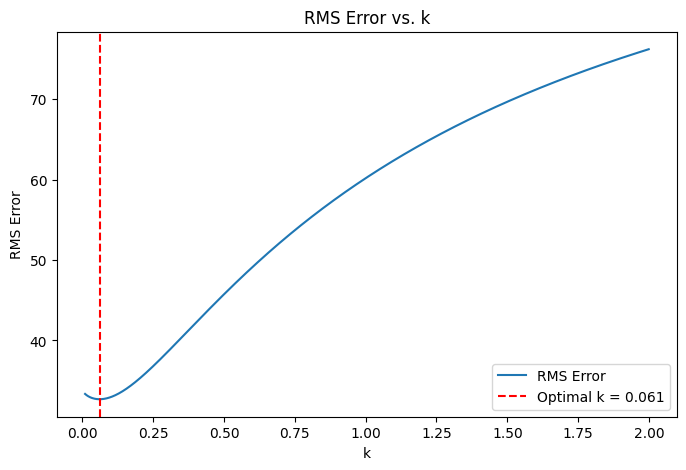

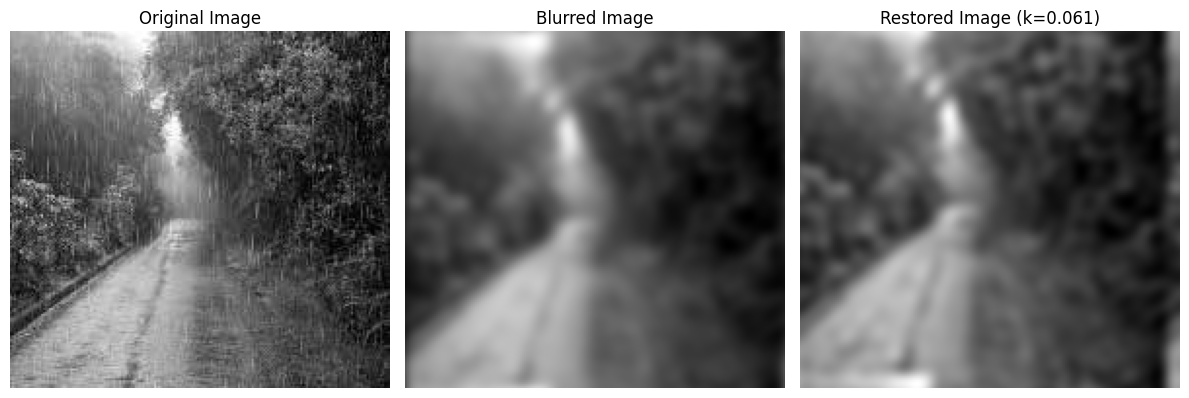

In [30]:
def wiener_inverse_with_k(degraded, psf, k):
    """
    Wiener deconvolution with user-defined k.
    """
    # Step 1: pad PSF to same size as image
    psf_padded = np.zeros_like(degraded)
    kh, kw = psf.shape
    psf_padded[:kh, :kw] = psf

    # Step 2: FFTs
    H = np.fft.fft2(psf_padded)
    G = np.fft.fft2(degraded)

    # Step 3: Wiener filter formula
    H_mag2 = np.abs(H)**2
    eps = 1e-12
    F_est = (H_mag2 / (H_mag2 + k)) * (G / (H + eps))

    # Step 4: inverse FFT back to spatial domain
    restored = np.real(np.fft.ifft2(F_est))
    return restored

# Experiment setup
k_values = np.arange(0.01, 2.0, 0.001)
rms_errors = []

for k in k_values:
    restored = wiener_inverse_with_k(blurry, psf, k)
    rms = np.sqrt(np.mean((gray - restored)**2))
    rms_errors.append(rms)

# Find optimal k
optimal_k = k_values[np.argmin(rms_errors)]
min_rms = np.min(rms_errors)

# Plot RMS error vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, rms_errors, label="RMS Error")
plt.axvline(optimal_k, color='r', linestyle='--', label=f"Optimal k = {optimal_k:.3f}")
plt.xlabel("k")
plt.ylabel("RMS Error")
plt.title("RMS Error vs. k")
plt.legend()
plt.show()

# Visual comparison
restored_optimal = wiener_inverse_with_k(blurry, psf, optimal_k)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(gray, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Blurred Image")
plt.imshow(blurry, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Restored Image (k={optimal_k:.3f})")
plt.imshow(restored_optimal, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

In [31]:
image = plt.imread("cameraman.jpeg").astype(float)
if image.ndim == 3:  # Convert RGB to grayscale
    gray = 0.299 * image[..., 0] + 0.587 * image[..., 1] + 0.114 * image[..., 2]
else:
    gray = image

psf = gaussian_psf(size=15, sigma=3)

# --- Step 3: Apply blur ---
blurry = convolve2d(gray, psf, mode='same', boundary='wrap')

sigmas = [0, 0.01, 1]

noisy_images = [add_gaussian_noise(blurry, s) for s in sigmas]

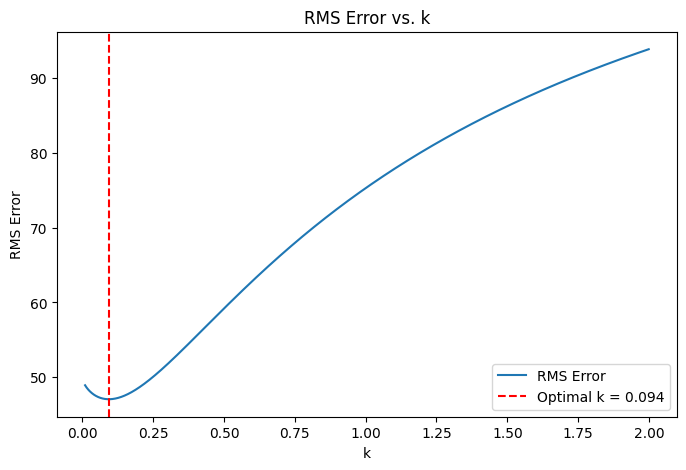

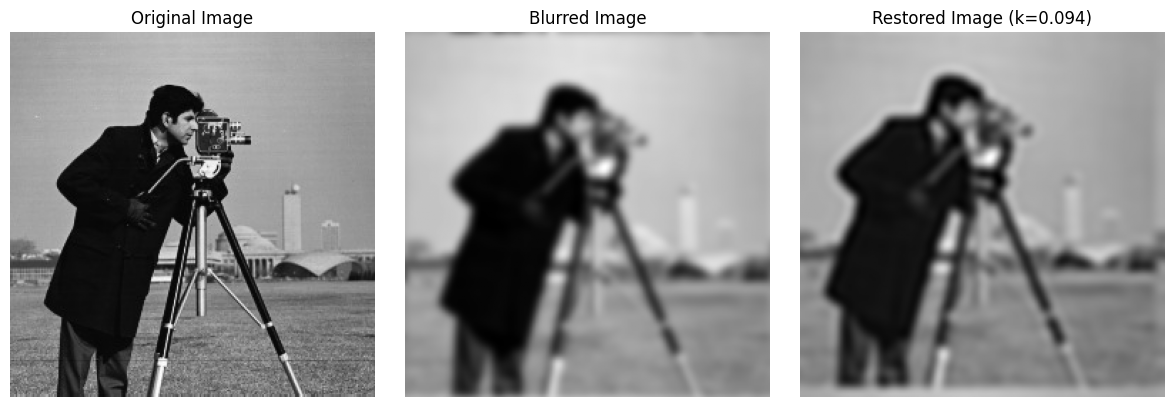

In [32]:
def wiener_inverse_with_k(degraded, psf, k):
    """
    Wiener deconvolution with user-defined k.
    """
    # Step 1: pad PSF to same size as image
    psf_padded = np.zeros_like(degraded)
    kh, kw = psf.shape
    psf_padded[:kh, :kw] = psf

    # Step 2: FFTs
    H = np.fft.fft2(psf_padded)
    G = np.fft.fft2(degraded)

    # Step 3: Wiener filter formula
    H_mag2 = np.abs(H)**2
    eps = 1e-12
    F_est = (H_mag2 / (H_mag2 + k)) * (G / (H + eps))

    # Step 4: inverse FFT back to spatial domain
    restored = np.real(np.fft.ifft2(F_est))
    return restored

# Experiment setup
k_values = np.arange(0.01, 2.0, 0.001)
rms_errors = []

for k in k_values:
    restored = wiener_inverse_with_k(blurry, psf, k)
    rms = np.sqrt(np.mean((gray - restored)**2))
    rms_errors.append(rms)

# Find optimal k
optimal_k = k_values[np.argmin(rms_errors)]
min_rms = np.min(rms_errors)

# Plot RMS error vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, rms_errors, label="RMS Error")
plt.axvline(optimal_k, color='r', linestyle='--', label=f"Optimal k = {optimal_k:.3f}")
plt.xlabel("k")
plt.ylabel("RMS Error")
plt.title("RMS Error vs. k")
plt.legend()
plt.show()

# Visual comparison
restored_optimal = wiener_inverse_with_k(blurry, psf, optimal_k)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(gray, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Blurred Image")
plt.imshow(blurry, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Restored Image (k={optimal_k:.3f})")
plt.imshow(restored_optimal, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()